# Setup

**Imports**

In [51]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import seaborn as sns
from scipy.signal import chirp, spectrogram, stft, sweep_poly, find_peaks

from pygsp import graphs
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform
import re
from math import asin, cos, radians, sin, sqrt
from loadmydata.load_molene_meteo import load_molene_meteo_dataset

import contextily as cx
import geopandas
import seaborn as sns

import utils
rng = np.random.default_rng()

# !pip install ruptures
import ruptures as rpt # we use the rupture package for change-point detection

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [2]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [3]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


### Dual-tone Multi-frequency Signaling

**Dual-tone multi-frequency signaling** is a procedure to encode symbols using an audio signal. The possible symbols are 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, *, #, A, B, C, and D. A symbol is represented by a sum of cosine waves: for \( t = 0, 1, \dots, T - 1 \),

$$
y_t = \cos\left( \frac{2\pi f_1 t}{f_s} \right) + \cos\left( \frac{2\pi f_2 t}{f_s} \right)
$$
where each combination of $(f_1, f_2)$ represents a symbol. The first frequency has four different levels (low frequencies), and the second frequency has four other levels (high frequencies); there are 16 possible combinations.

By reading the page from the [link](https://en.wikipedia.org/wiki/DTMF), we find the DTMF Keypad Frequencies (with sound clips) table:

|          | **1209 Hz** | **1336 Hz** | **1477 Hz** | **1633 Hz** |
|----------|---------|---------|---------|---------|
| **697 Hz** | 1       | 2       | 3       | A       |
| **770 Hz** | 4       | 5       | 6       | B       |
| **852 Hz** | 7       | 8       | 9       | C       |
| **941 Hz** | *       | 0       | #       | D       |


In [ ]:
def detect_frequency_line(i, spectrogram_seg, min_line_length=4, energy_threshold=0.3):
    intensity = spectrogram_seg[i, :]
    above_threshold = intensity > energy_threshold * np.max(intensity)

    count = 0
    for val in above_threshold:
        if val:
            count += 1
            if count >= min_line_length:
                return True
        else:
            count = 0

    return False

def plot_spectrogram_and_symbolisation(t, f, spectrogram, breakpoints, symb):
    # Create the plots
    fig = plt.figure(figsize=(12, 8))
    plt.pcolormesh(t, f, spectrogram)
    plt.colorbar()
    for b in breakpoints[:-1]:
        plt.axvline(t[b], c="y")
    for i in range(len(breakpoints) - 1):
        if i >= len(symb) or symb[i] is None:
            plt.plot([t[breakpoints[i] + 1], t[breakpoints[i + 1] - 1]], [f[0], f[0]], c="white", lw=1)
            plt.plot([t[breakpoints[i] + 1], t[breakpoints[i + 1] - 1]], [f[-1], f[-1]], c="white", lw=1)
        else:
            freq1, freq2 = symb[i]
            plt.plot([t[breakpoints[i] + 1], t[breakpoints[i + 1] - 1]], [freq1, freq1], c="green", lw=1)
            plt.plot([t[breakpoints[i] + 1], t[breakpoints[i + 1] - 1]], [freq2, freq2], c="red", lw=1)

    plt.show()

In [27]:
def symbolize(signal, pen, energy_threshold, plot=False, determinist=False, f1 = [697, 770, 852, 941], f2 = [1209, 1336, 1477, 1633], n_bkps=None, encoding_dic=None):
    f, t, Zxx = stft(signal, fs=22050, noverlap=256, nperseg=512, padded=True)

    model = rpt.Binseg(model="l2", jump=1).fit(signal=np.abs(Zxx).T)
    if n_bkps is None:
        bkps = model.predict(pen=pen)
    else:
        bkps = model.predict(n_bkps=n_bkps)

    bkps.insert(0, 0)

    subsegments = [np.abs(Zxx)[:, bkps[i]:bkps[i+1]] for i in range(len(bkps) - 1)]

    encoding = []
    pauses = []
    max_id = len([value for value in f if value <= f2[-1] + 50])

    for i, segment in enumerate(subsegments):
        segment_energy = np.mean(segment[:max_id + 1, :], axis=1)
        dominant_idx = np.argsort(segment_energy)[::-1][:2]

        valid_lines = [
            detect_frequency_line(np.argmin(np.abs(f - freq)), segment, min_line_length=4, energy_threshold=energy_threshold)
            for freq in [f[dominant_idx[0]], f[dominant_idx[1]]]
        ]

        if not all(valid_lines):
            pauses.append(True)
            encoding.append(None)
        else:
            pauses.append(False)
            freq1 = min(f1, key=lambda fr: abs(min(f[dominant_idx[0]], f[dominant_idx[1]]) - fr))
            freq2 = min(f2, key=lambda fr: abs(max(f[dominant_idx[0]], f[dominant_idx[1]]) - fr))
            encoding.append((freq1, freq2))

    filtered_encoding = []
    for i in range(len(encoding)):
        if i > 0 and encoding[i] == encoding[i - 1] and not pauses[i]:
            filtered_encoding.append((None))
            continue
        filtered_encoding.append(encoding[i])
    encoding = filtered_encoding

    if plot:
        fig = plt.figure(figsize=(12, 8))
        plt.pcolormesh(t, f, np.abs(Zxx))
        plt.colorbar()
        for b in bkps[:-1]:
            plt.axvline(t[b], c="y")
        for i in range(len(bkps) - 1):
            if i >= len(encoding) or encoding[i] is None:
                plt.plot([t[bkps[i] + 1], t[bkps[i + 1] - 1]], [f[0], f[0]], c="white", lw=2)
                plt.plot([t[bkps[i] + 1], t[bkps[i + 1] - 1]], [f[-1], f[-1]], c="white", lw=2)
            else:
                f1, f2 = encoding[i]
                plt.plot([t[bkps[i] + 1], t[bkps[i + 1] - 1]], [f1, f1], c="white", lw=2)
                plt.plot([t[bkps[i] + 1], t[bkps[i + 1] - 1]], [f2, f2], c="white", lw=2)

        plt.show()

    if determinist:
        encoding = [item for item in encoding if item is not None]

    if encoding_dic is None:
        return encoding
    else:
        return [encoding_dic[x] for x in encoding if x is not None]


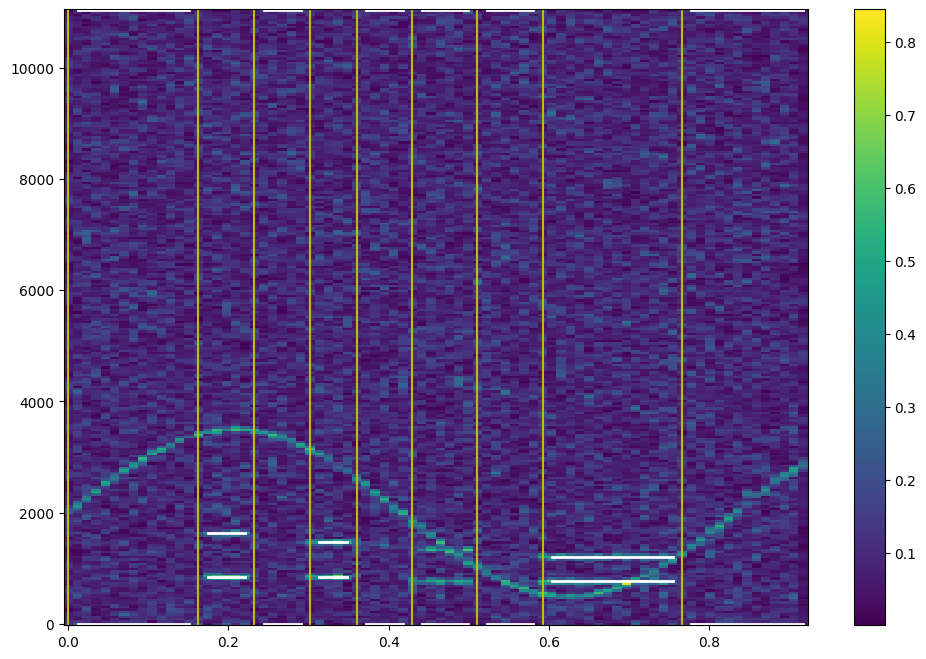

[None, (852, 1633), None, (852, 1477), None, None, None, (770, 1209), None]

In [28]:
pen=1.5
energy_threshold=0.6
symbolize(X_train[5], pen, energy_threshold, plot=True)


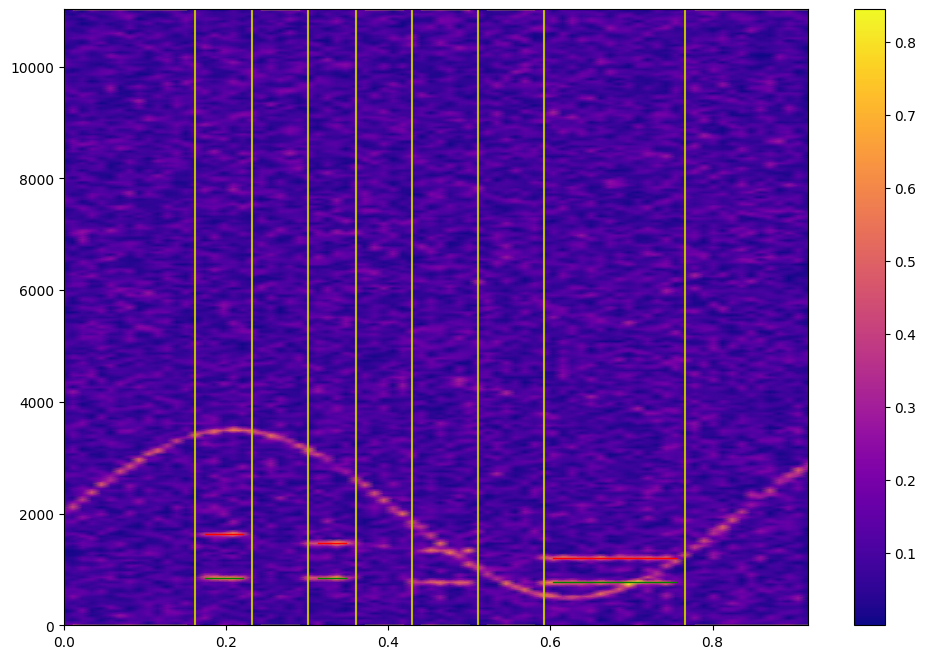

In [ ]:
def symbolise_one_signal(signal, pen, energy_threshold, symbol_dic=None, num_breakpoints=None, determinist=False, plot=True):

    # compute spectrogram of the signal
    f, t, Zxx = stft(signal, fs=FS, noverlap=256, nperseg=512, padded=True)
    
    spectro = np.abs(Zxx)

    model = rpt.Binseg(model="l2", jump=1).fit(signal=spectro.T)

    if num_breakpoints is None:
        breakpoints = model.predict(pen=pen)
    else:
        breakpoints = model.predict(n_bkps=num_breakpoints)

    breakpoints.insert(0, 0) # insert the origin

    segments = []

    for i in range(len(breakpoints) - 1):
        spec_seg = spectro[:, breakpoints[i]:breakpoints[i+1]]
        segments.append(spec_seg)
        
    symbolisation = []
    pause_list = []
    max_id = len([value for value in f if value <= f2[-1] + 50])

    for index, seg in enumerate(segments):
        seg_energy = np.mean(seg[:max_id + 1, :], axis=1)
        dominant_idx = np.argsort(seg_energy)[::-1][:2]

        valid_lines = [
            detect_frequency_line(np.argmin(np.abs(f - freq)), seg, 4, energy_threshold)
            for freq in [f[dominant_idx[0]], f[dominant_idx[1]]]
        ]

        if not all(valid_lines):
            pause_list.append(True)
            symbolisation.append(None)
        else:
            pause_list.append(False)
            low_freq = min(freq1, key=lambda k: abs(min(f[dominant_idx[0]], f[dominant_idx[1]]) - k))
            high_freq = min(freq2, key=lambda k: abs(max(f[dominant_idx[0]], f[dominant_idx[1]]) - k))
            symbolisation.append((low_freq, high_freq))

    # filter segments to avoid pauses
    filtered_symbolisation = []
    for i in range(len(symbolisation)):
        if i > 0 and symbolisation[i] == symbolisation[i - 1] and not pause_list[i]:
            filtered_symbolisation.append((None))
            continue
        filtered_symbolisation.append(symbolisation[i])
    
    final_symbolisation = filtered_symbolisation

    if plot:
        plot_spectrogram_and_symbolisation(t, f, spectro, breakpoints, final_symbolisation)

    if determinist:
        final_symbolisation = [item for item in final_symbolisation if item is not None]

    if symbol_dic is None:
        return final_symbolisation, breakpoints
    else:
        return [symbol_dic[x] for x in final_symbolisation if x is not None], breakpoints
    
    pen=1.5
energy_threshold=0.6
final_symbolisation, breakpoints = symbolise_one_signal(X_train[7], pen, energy_threshold)

This looks good, now we try to fit this to $\texttt{X\_train[0]}$. To do so, we associate to each key in the DTMF alphabet the fequency segment that has been associated to this key the most over the dataset $\texttt{X\_train[0]}$. We leverage the fact that we are given $\texttt{y\_train[0]}$ by forcing the number of breakpoints to fit $\texttt{X\_train[0]}$ instead of using a penalization. 

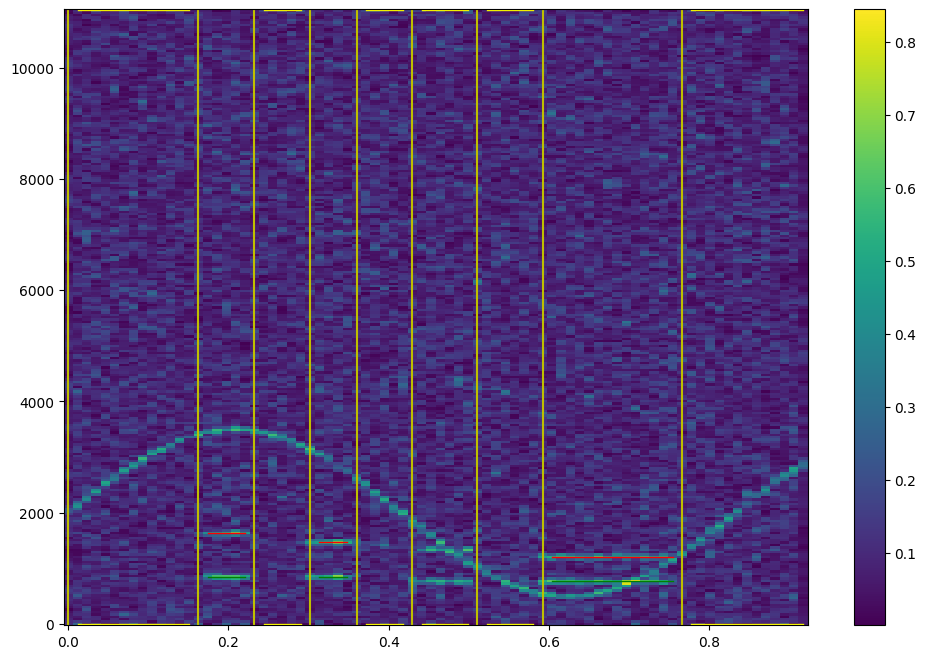

In [34]:
class DTMFEncoder(object):
    def __init__(self, signal, n_psc=512, n_overlap=512//2, pen=2, FS=22050, encoding_dic=None,
                 low_freqs=[697, 770, 852, 941],
                 high_freqs=[1209, 1336, 1477, 1633], n_bkps=None,
                 nrj=0.6):
        self.signal = signal
        self.n_psc = n_psc
        self.n_overlap = n_overlap
        self.pen = pen
        self.FS = FS
        self.encoding_dic = encoding_dic
        self.high_freqs = high_freqs
        self.low_freqs = low_freqs
        self.n_bkps = n_bkps
        self.nrj = nrj

    def is_line_present_at_frequency(self, Zxx_segment, freq_idx, min_line_length=4, energy_threshold=0.3):
        intensity_at_freq = Zxx_segment[freq_idx, :]
        above_threshold = intensity_at_freq > energy_threshold * np.max(intensity_at_freq)

        count = 0
        for val in above_threshold:
            if val:
                count += 1
                if count >= min_line_length:
                    return True
            else:
                count = 0

        return False

    def fit(self, verbose=False, determinist=False):
        f, t, Zxx = stft(self.signal, fs=self.FS, noverlap=self.n_overlap,
                         nperseg=self.n_psc, padded=True)

        self.f, self.t, self.Zxx = f, t, Zxx

        algo = rpt.Binseg(model="l2", jump=1).fit(signal=np.abs(Zxx).T)
        if self.n_bkps is None:
            self.bkps = algo.predict(pen=self.pen)
        else:
            self.bkps = algo.predict(n_bkps=self.n_bkps)

        self.bkps.insert(0, 0)

        subsegments = [np.abs(Zxx)[:, self.bkps[i]:self.bkps[i+1]] for i in range(len(self.bkps) - 1)]

        self.encoding = []
        pauses = []
        max_id = len([value for value in f if value <= self.high_freqs[-1] + 50])

        for i, segment in enumerate(subsegments):
            segment_energy = np.mean(segment[:max_id + 1, :], axis=1)
            dominant_idx = np.argsort(segment_energy)[::-1][:2]

            valid_lines = [
                self.is_line_present_at_frequency(segment, np.argmin(np.abs(f - freq)), min_line_length=4, energy_threshold=self.nrj)
                for freq in [f[dominant_idx[0]], f[dominant_idx[1]]]
            ]

            if not all(valid_lines):
                pauses.append(True)
                self.encoding.append(None)
            else:
                pauses.append(False)
                f1 = min(self.low_freqs, key=lambda fr: abs(min(f[dominant_idx[0]], f[dominant_idx[1]]) - fr))
                f2 = min(self.high_freqs, key=lambda fr: abs(max(f[dominant_idx[0]], f[dominant_idx[1]]) - fr))
                self.encoding.append((f1, f2))

        filtered_encoding = []
        for i in range(len(self.encoding)):
            if i > 0 and self.encoding[i] == self.encoding[i - 1] and not pauses[i]:
                filtered_encoding.append((None))
                continue
            filtered_encoding.append(self.encoding[i])
        self.encoding = filtered_encoding

        if verbose:
            fig = plt.figure(figsize=(12, 8))
            plt.pcolormesh(t, f, np.abs(Zxx))
            plt.colorbar()
            for b in self.bkps[:-1]:
                plt.axvline(t[b], c="y")
            for i in range(len(self.bkps) - 1):
                if i >= len(self.encoding) or self.encoding[i] is None:
                    plt.plot([t[self.bkps[i] + 1], t[self.bkps[i + 1] - 1]], [f[0], f[0]], c="yellow", lw=1)
                    plt.plot([t[self.bkps[i] + 1], t[self.bkps[i + 1] - 1]], [f[-1], f[-1]], c="yellow", lw=1)
                else:
                    f1, f2 = self.encoding[i]
                    plt.plot([t[self.bkps[i] + 1], t[self.bkps[i + 1] - 1]], [f1, f1], c="green", lw=1)
                    plt.plot([t[self.bkps[i] + 1], t[self.bkps[i + 1] - 1]], [f2, f2], c="red", lw=1)

            plt.show()

        if determinist:
            self.encoding = [item for item in self.encoding if item is not None]

        if self.encoding_dic is None:
            return self.encoding
        else:
            return [self.encoding_dic[x] for x in self.encoding if x is not None]


idx = 5
encoder = DTMFEncoder(X_train[idx], pen=1.5)
encoding = encoder.fit(verbose=True, determinist=True)


In [29]:
from collections import Counter

In [ ]:
raw_dic = {key:[] for key in [f"{i}" for i in range(0,10)] + ["A", "B", "C", "D", "*", "#"]}

for index, x in enumerate(X_train):
    final_symbolisation, _ = symbolise_one_signal(x, pen, energy_threshold, plot=False)   
    for k, v in zip(y_train[index], final_symbolisation):
        raw_dic[k].append(v)

fit_dic = {}

visit = set()

for k, v in raw_dic.items():

    counter = Counter(v)

    most_freqent = counter.most_common()

    for val, _ in most_freqent:
        if val not in visit:

            fit_dic[k] = val
            visit.add(val)
            break

symbolizer = {v: k for k, v in fit_dic.items()}

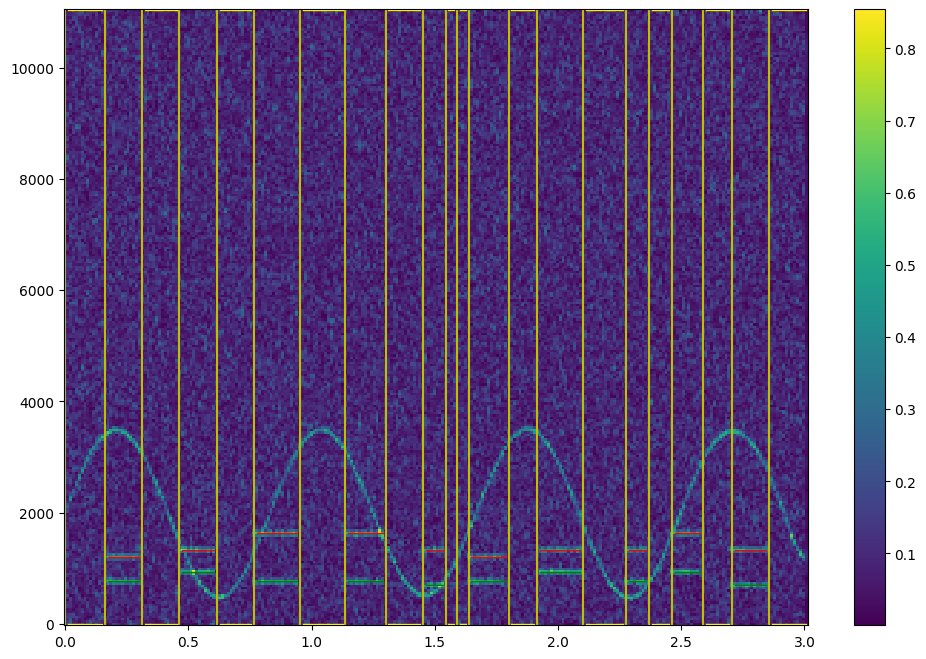

KeyError: (941, 1336)

In [36]:
idx = 10
encoder = DTMFEncoder(X_train[idx], pen=1.5, nrj=0.5, encoding_dic = symbolizer)
encoding = encoder.fit(verbose=True, determinist=True)
print(encoding)

# Question 2

In [37]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

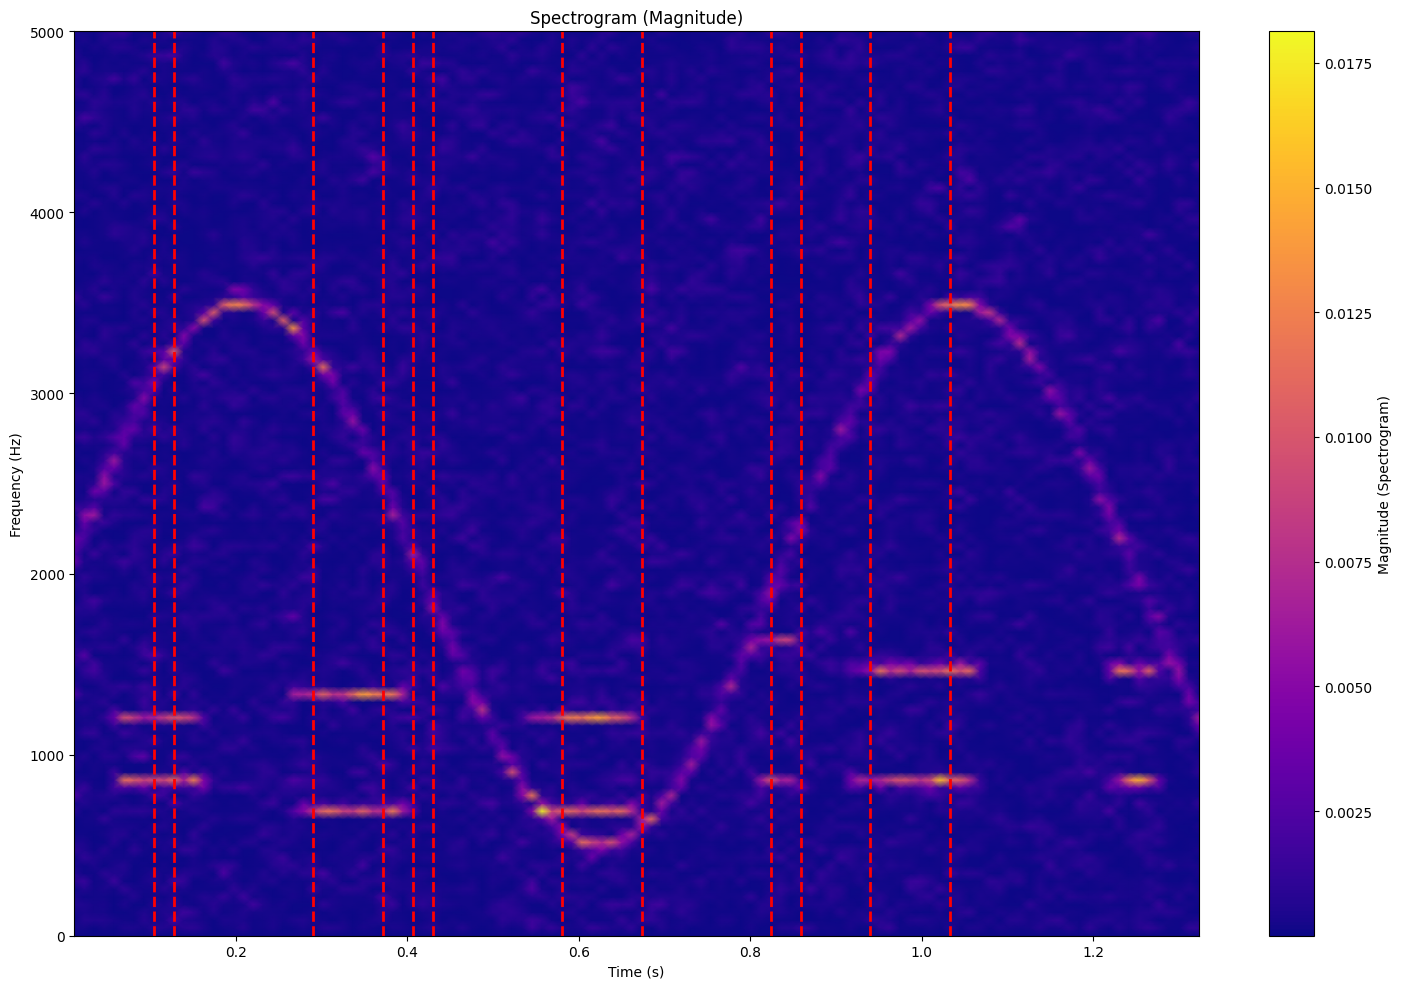

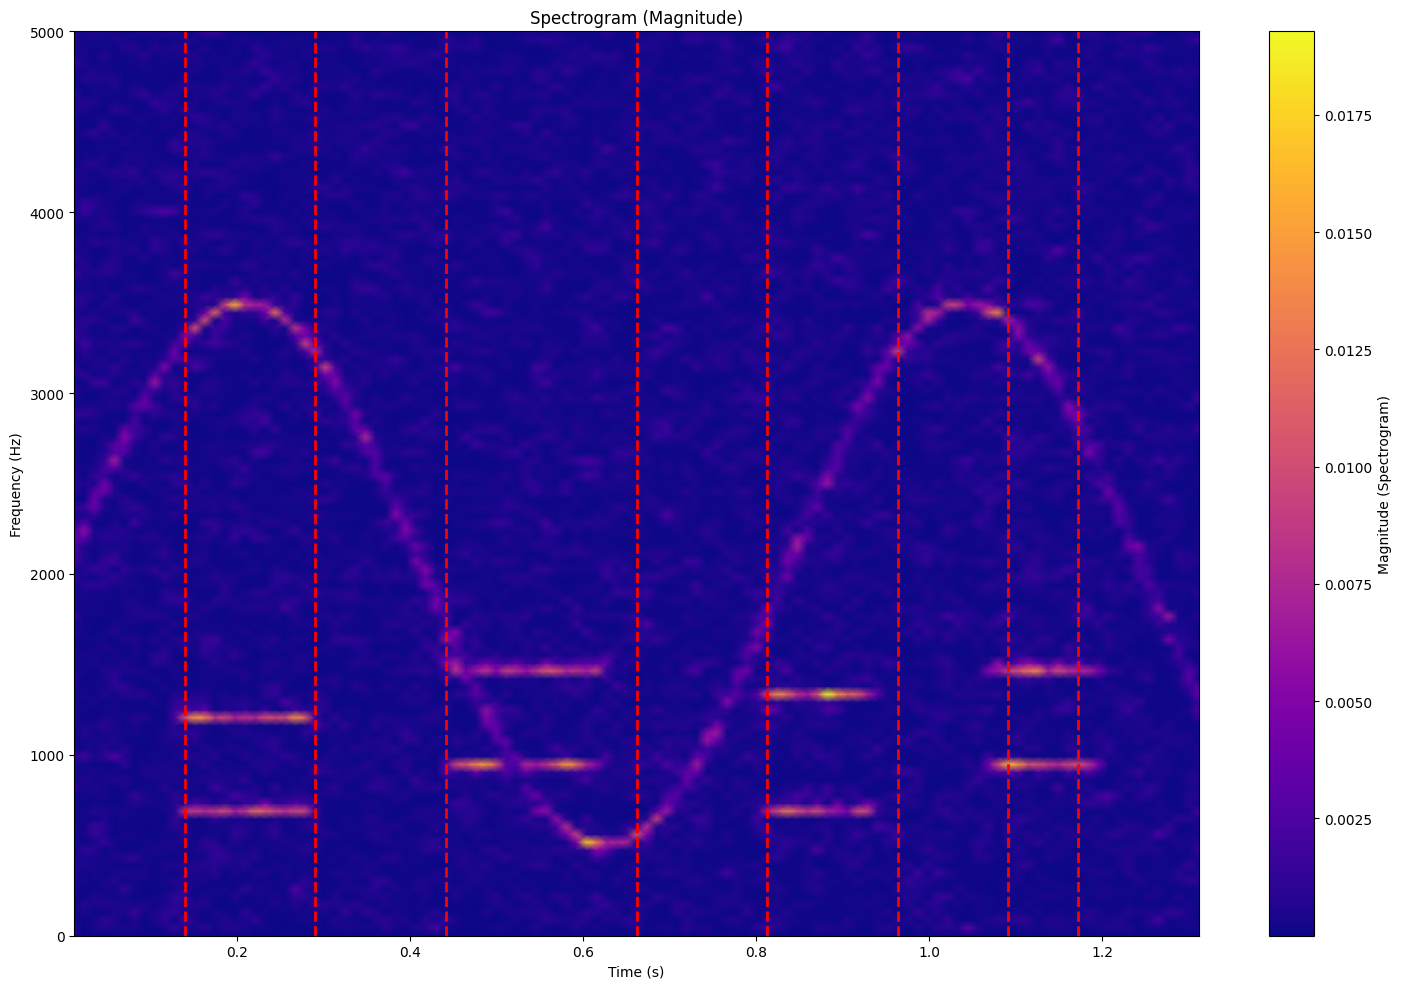

symbolisation échantillon test 0 : ['7', '2', '1', '1', 'C', '9']
symbolisation échantillon test 1 : ['1', '#', '2', '#']


In [17]:
symbolisation_0, _ = detect_change_points_adjusted(X_test[0], min_break_time=0.05, energy_threshold=0.10, plot=True)
symbolisation_1, _ = detect_change_points_adjusted(X_test[1], min_break_time=0.05, energy_threshold=0.10, plot=True)
print(f'symbolisation échantillon test 0 : {symbolisation_0}')
print(f'symbolisation échantillon test 1 : {symbolisation_1}')

# Question 3

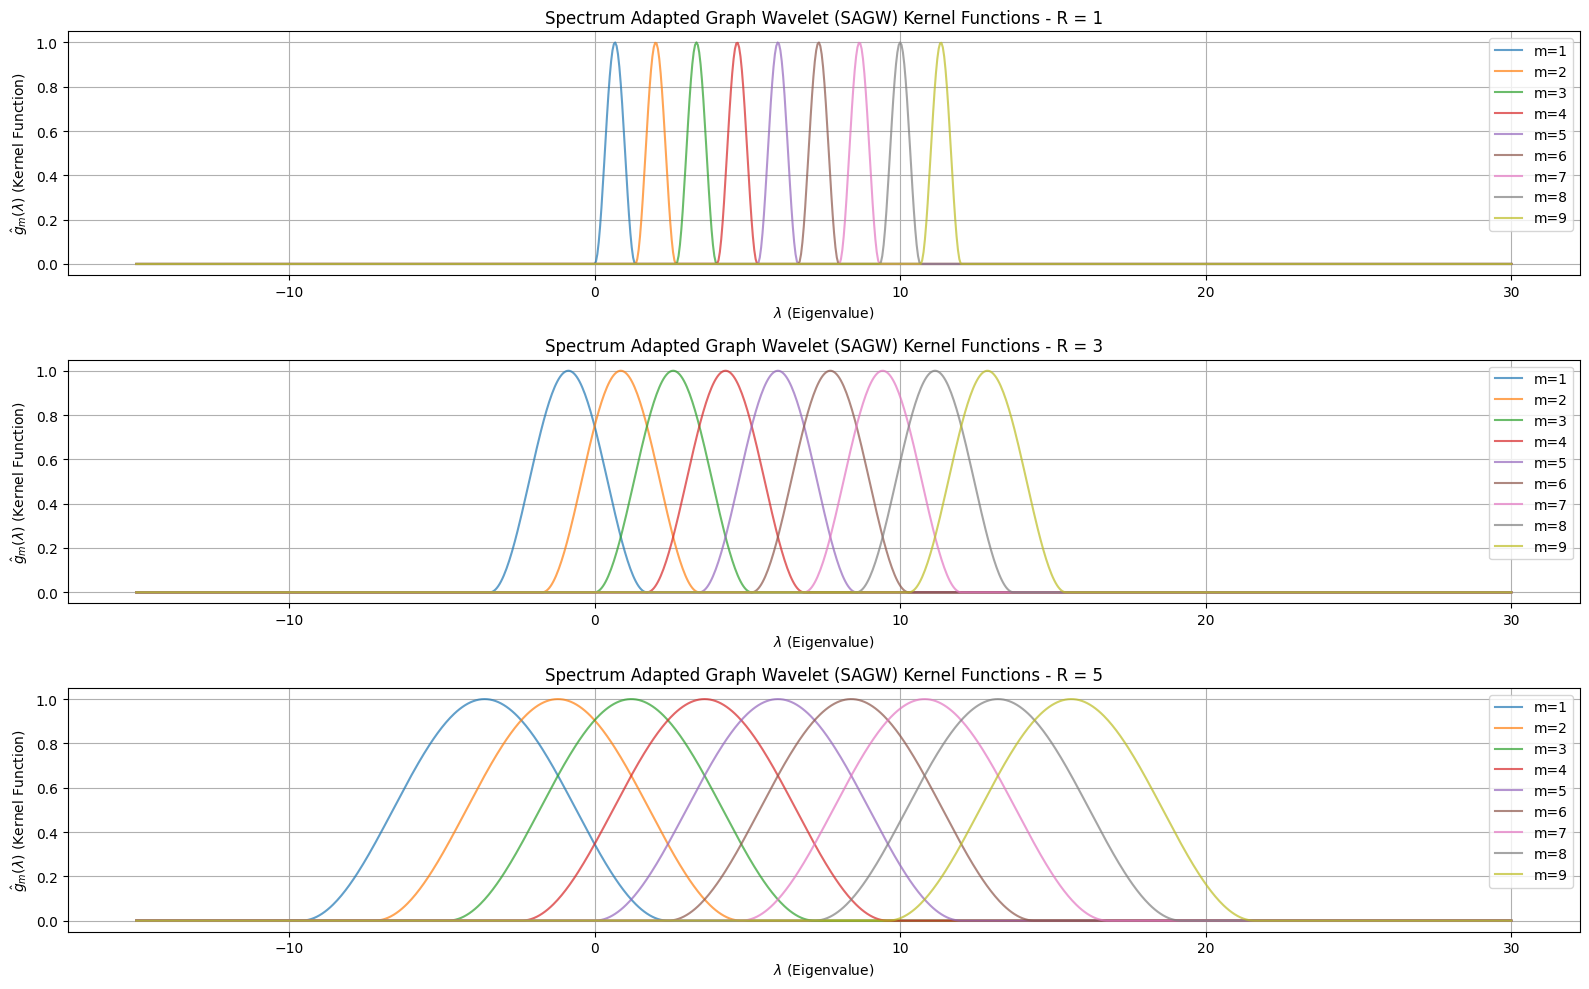

In [91]:
# Define the parameters
lambda_n = 12  # Maximum eigenvalue of the graph Laplacian
M = 9          # Number of scales
R_values = [1, 3, 5]         # Different values of R to plot
lambda_vals = np.linspace(-15, 30, 1000)  # Range of eigenvalue lambda for plotting

# Define the base kernel function g^U(lambda)
def g_U(lambda_val, R, a):
    return 0.5 * (1 + np.cos(2 * np.pi * (lambda_val / (a * R) + 0.5))) * np.logical_and(-R * a <= lambda_val, lambda_val <= 0).astype(float)

# Define the shifted kernel functions g_m(lambda)
def g_m(lambda_val, m, R, a):
    return g_U(lambda_val - a * m, R, a)

# Create the figure and axis
fig, ax = plt.subplots(len(R_values), 1, figsize=(16, 10))

# Plotting the kernels for different R values
for index, r in enumerate([1, 3, 5]):
    # Generate the kernel functions for all m = 1 to M
    a = lambda_n / (M + 1 - r)
    for m in range(1, M + 1):
        kernel_values = np.array([g_m(l, m, r, a) for l in lambda_vals])
        ax[index].plot(lambda_vals, kernel_values.T, label=f'm={m}', alpha=0.7)
        ax[index].set_title(f"Spectrum Adapted Graph Wavelet (SAGW) Kernel Functions - R = {r}")
        ax[index].set_xlabel(r"$\lambda$ (Eigenvalue)")
        ax[index].set_ylabel(r"$\hat{g}_m(\lambda)$ (Kernel Function)")
        ax[index].grid(True)

        # Display legend and show the plot
        ax[index].legend()

plt.tight_layout()
plt.show()

# Question 4

On récupère le code des fonctions du dernier TP

In [52]:
data_df, stations_df, description = load_molene_meteo_dataset()
# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

In [58]:
# Remove all stations with missing values in the temperature data.
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
columns_nan_series = temperature_df.isna().any()
stations_with_nan = list(columns_nan_series.index[columns_nan_series])
no_nan_temperature_df = temperature_df[columns_nan_series.index[~columns_nan_series]]
non_nan_stations_df = stations_df[~stations_df.Nom.isin(stations_with_nan)].reset_index(drop=True, inplace=False)
print(f"Stations containing at least one NaN value: {stations_with_nan}")

Stations containing at least one NaN value: ['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


In [54]:
CRS = "EPSG:4326"

# Convert pandas DataFrame to GeoPandas GeoDataFrame
station_geodata = geopandas.GeoDataFrame(
    non_nan_stations_df,
    geometry=geopandas.points_from_xy(non_nan_stations_df.Longitude, non_nan_stations_df.Latitude),
).set_crs(CRS)

In [55]:
def get_geodesic_distance(point_1, point_2):
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r


# util functions from the last tutorial

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [56]:
# Compute the distance matrix
station_coordinates = non_nan_stations_df[["Longitude", "Latitude"]].to_numpy()
pairwise_distances = pdist(station_coordinates, metric=get_geodesic_distance)
distance_median = np.median(pairwise_distances)  # Median heuristic for sigma

# Find the maximum threshold of a connected graph
distance_thresholds = np.linspace(1, 0, 1000)
optimal_threshold = 0
for i in range(len(distance_thresholds)):
    gaussian_similarity_matrix = squareform(
        get_exponential_similarity(pairwise_distances, distance_median, distance_thresholds[i])
    )
    graph = graphs.Graph(gaussian_similarity_matrix)
    if graph.is_connected(recompute=True) and np.mean(graph.d) > 3:
        optimal_threshold = distance_thresholds[i]
        break

print("Optimal Threshold: {:.4f}".format(optimal_threshold))
print(
    f"The graph is {'not ' if not graph.is_connected(recompute=True) else ''}connected, "
    f"with average degree {np.mean(graph.d):.2f}"
)


Optimal Threshold: 0.8318
The graph is connected, with average degree 4.05


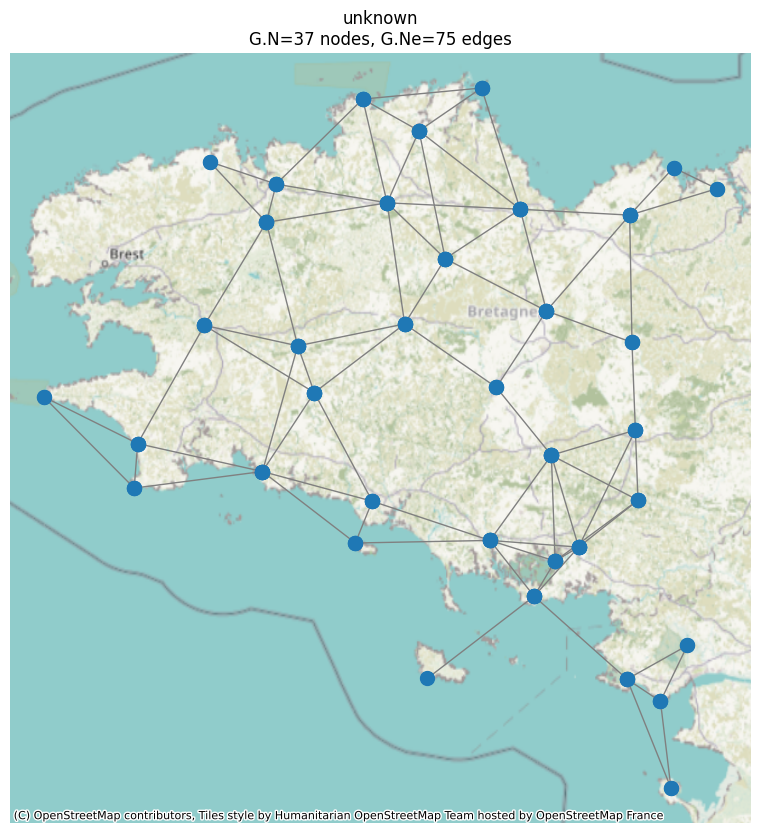

In [57]:
# Plot the stations on a map with the graph overlay
ax = station_geodata.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=station_geodata.crs.to_string(), zoom=8)
ax.set_axis_off()
graph.set_coordinates(station_coordinates)
graph.plot(ax=ax)

In [59]:
laplacian_matrix = graph.L.todense()
signal_smoothness = []

# Calculate smoothness for each temperature signal
for day_index in range(len(no_nan_temperature_df)):
    signal_smoothness.append(
        no_nan_temperature_df.iloc[day_index].T @ laplacian_matrix @ no_nan_temperature_df.iloc[day_index]
    )
signal_smoothness = np.array(signal_smoothness)

# Identify the days with minimum and maximum smoothness
day_with_min_smoothness = np.argmin(signal_smoothness)
day_with_max_smoothness = np.argmax(signal_smoothness)

# Print smoothness statistics
print("Average smoothness: {:.2f}".format(np.mean(signal_smoothness)))
print("Day with least smoothness: {}".format(no_nan_temperature_df.index[day_with_max_smoothness]))
print("Day with highest smoothness: {}".format(no_nan_temperature_df.index[day_with_min_smoothness]))

Average smoothness: 326.77
Day with least smoothness: 2014-01-10 09:00:00
Day with highest smoothness: 2014-01-24 19:00:00


In [66]:
day_with_min_smoothness

571

# Question 5

In [68]:
def compute_W_at_index(signal, graph):
    """
    Computes the W matrix over the graph given a signal. W is a matrix of size M x Number of nodes in the graph
    """
    eigen_val, eigen_vec = eigh(graph.L.todense())
    num_nodes = eigen_vec.shape[1]
    W = np.zeros((M, num_nodes))
    #W = np.zeros((M, len(eigenvects)))
    g = np.array([g_m(eigen_val, m=m, R=3) for m in range(1, M + 1)])
    f_hat = signal.T @ eigen_vec
    W = np.zeros((M, len(signal)))

    # Compute wavelet coefficients for all scales and nodes
    for m in range(M):
        for v in range(len(signal)):
            W[m, v] = np.sum(g[m, :] * f_hat * eigen_vec[v, :])

    return W

def classify_W(W):
    """
    Transforms a real valued W matrix into a vector of length number of nodes, encoding the class of the nodes among [low, medium, high]
    """
    low_frequency = np.sum(np.abs(W[:3, :])**2, axis=0) 
    med_frequency = np.sum(np.abs(W[3:6, :])**2, axis=0) 
    high_frequency = np.sum(np.abs(W[6:, :])**2, axis=0)
    energy = np.stack([low_frequency, med_frequency, high_frequency])
    return np.argmax(energy, axis=0)


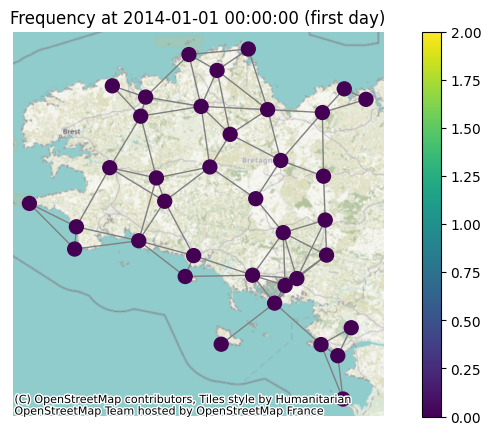

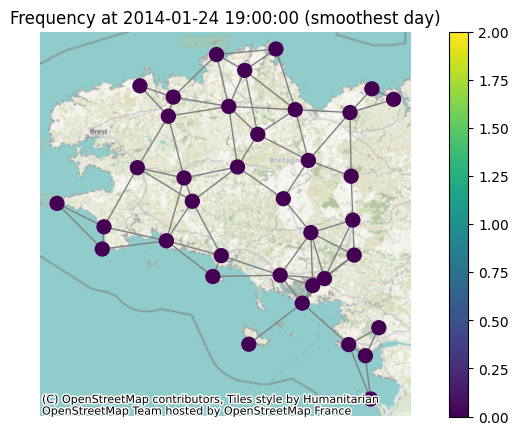

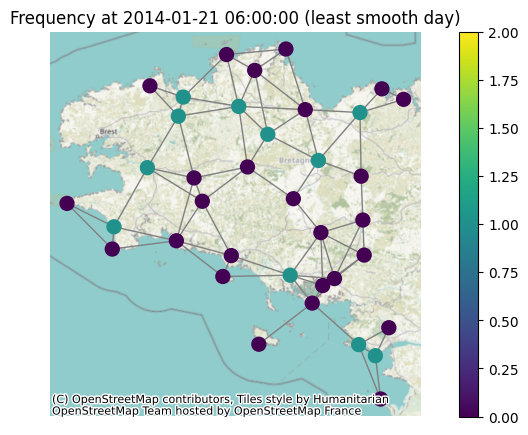

In [70]:
idx_least_smooth = np.int64(486)
W_init = compute_W_at_index(no_nan_temperature_df.iloc[0], graph)
W_smoothest = compute_W_at_index(
    no_nan_temperature_df.iloc[day_with_min_smoothness], graph
)
W_least_smooth = compute_W_at_index(
    no_nan_temperature_df.iloc[idx_least_smooth], graph
)

W_init_classified = classify_W(W_init)
W_smoothest_classified = classify_W(W_smoothest)
W_least_smooth_classified = classify_W(W_least_smooth)

for day, W in {
    f"{no_nan_temperature_df.index[0]} (first day)": W_init_classified,
    f"{no_nan_temperature_df.index[day_with_min_smoothness]} (smoothest day)": W_smoothest_classified,
    f"{no_nan_temperature_df.index[idx_least_smooth]} (least smooth day)": W_least_smooth_classified,
}.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = station_geodata.geometry.plot(ax=ax)
    cx.add_basemap(ax, crs=station_geodata.crs.to_string(), zoom=8)
    ax.set_axis_off()
    
    graph.set_coordinates(station_coordinates)
    graph.plot_signal(W, ax=ax, limits=[0, 2])
    
    ax.set_title(f"Frequency at {day}")
    plt.show()

# Question 6

/var/folders/kd/c_69_lv95n33jqfn1l50n0ww0000gn/T/ipykernel_846/3837050500.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0: Low', '', '', '', '1: Medium', '', '', '', '2: High'])


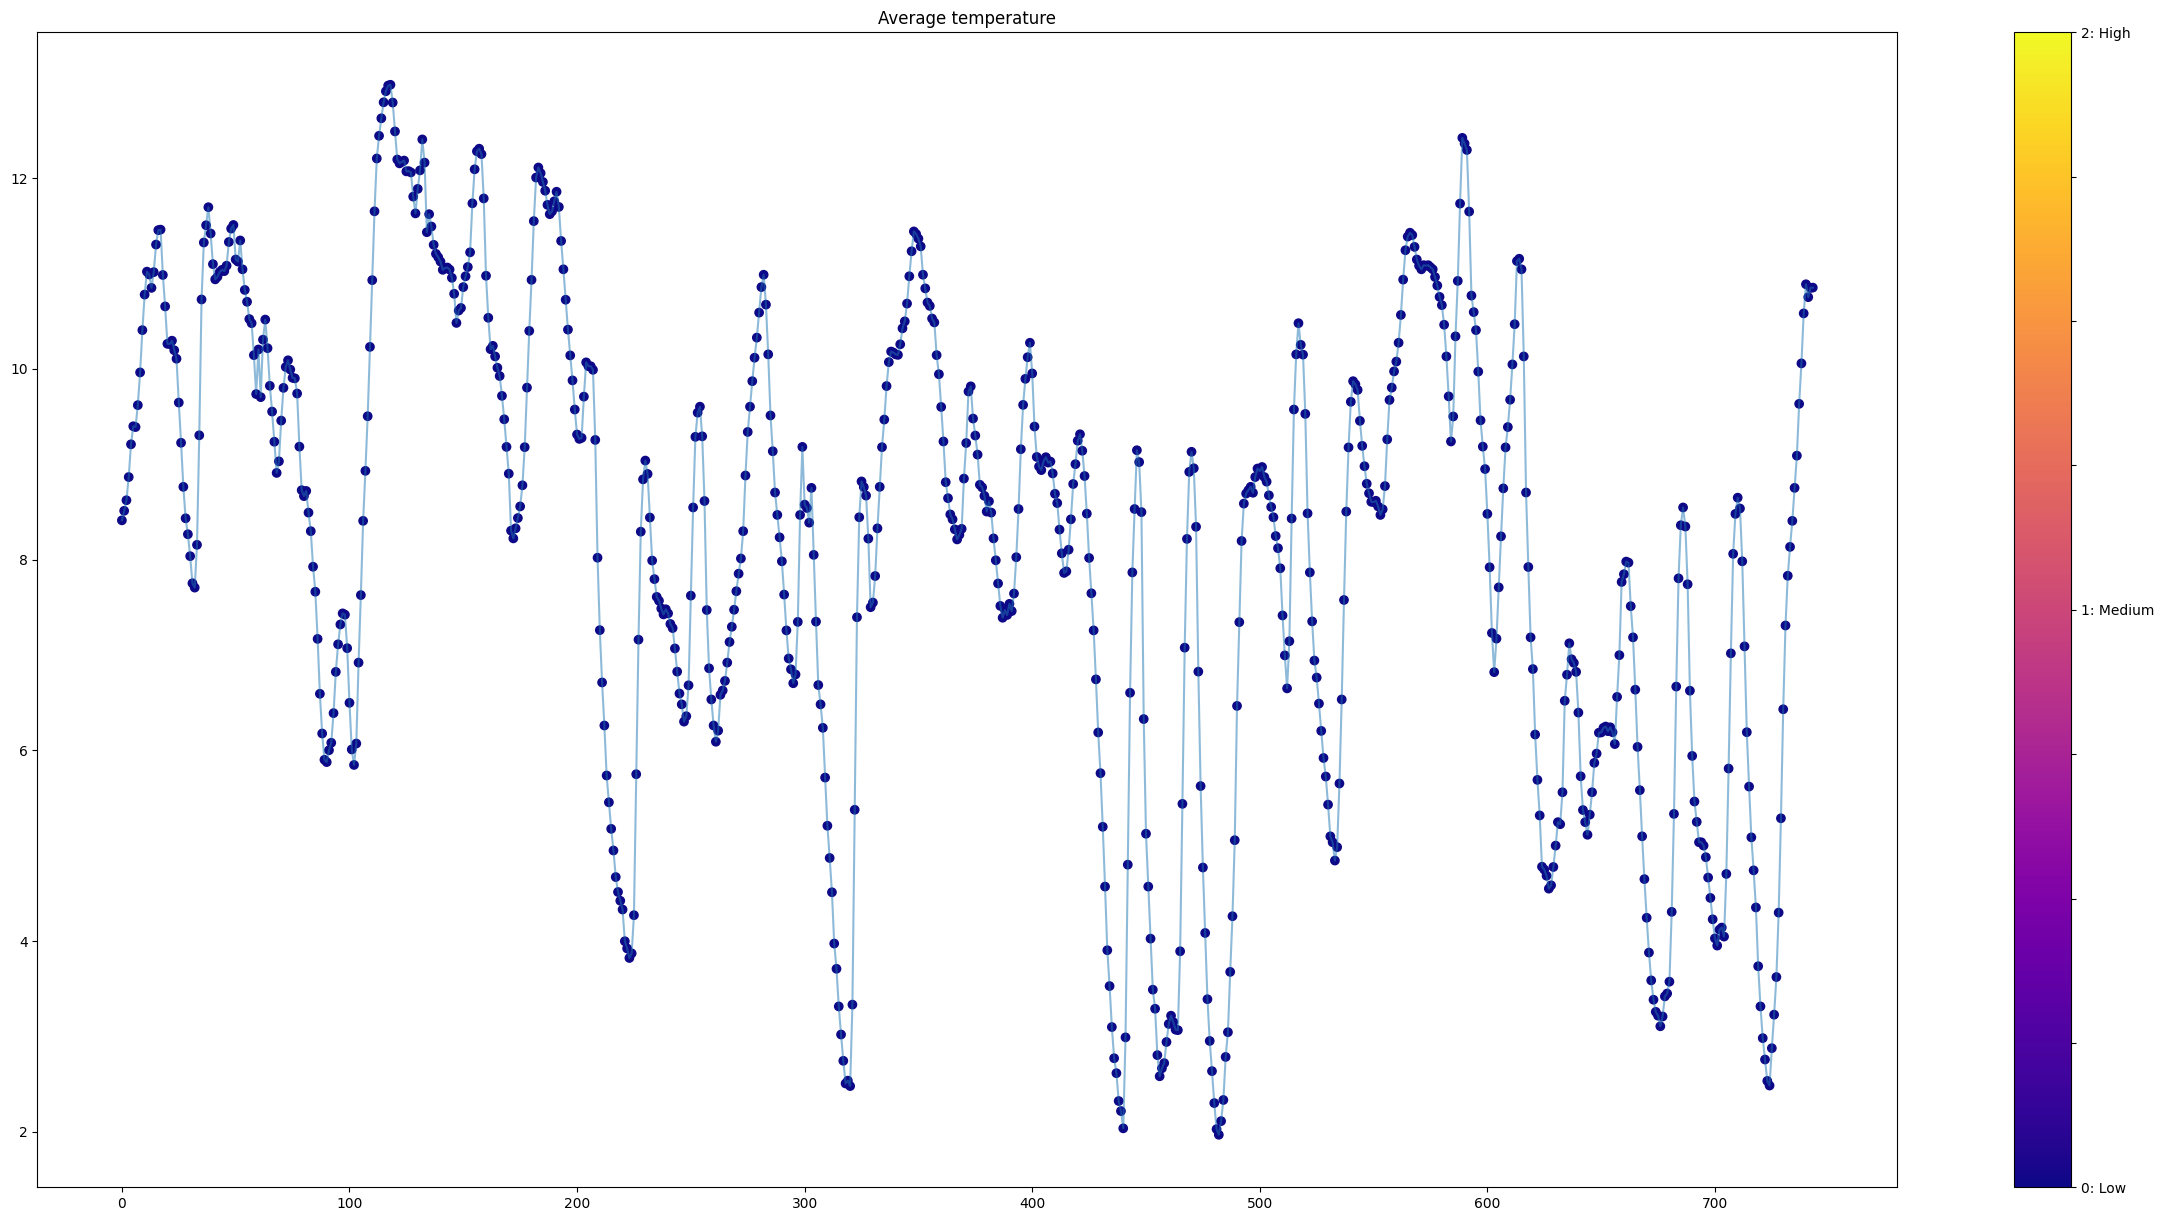

In [75]:
major_class = []
time_range = no_nan_temperature_df.index
for t in time_range:
    W = compute_W_at_index(no_nan_temperature_df.loc[t], graph)
    W_classified = classify_W(W)
    values, counts = np.unique(W_classified, return_counts=True)
    major_value = values[np.argmax(counts)]
    major_class.append(major_value)
major_class = np.array(major_class)

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(30, 15))

# Affichage de la température moyenne pour chaque timestamp avec les marqueurs adaptés
ax.plot(np.arange(no_nan_temperature_df.mean(axis=1).shape[0]), no_nan_temperature_df.mean(axis=1), alpha=0.5)
scatter = ax.scatter(
    np.arange(no_nan_temperature_df.mean(axis=1).shape[0]),
    no_nan_temperature_df.mean(axis=1),
    c=major_class,
    cmap="plasma",  # Modification de la colormap ici
    vmin=0,
    vmax=2
)

# Ajout de la barre de couleur
cbar = plt.colorbar(scatter)
ax.set_title('Average temperature')  # Titre du graphique
cbar.ax.set_yticklabels(['0: Low', '', '', '', '1: Medium', '', '', '', '2: High'])

plt.show()

# Question 7

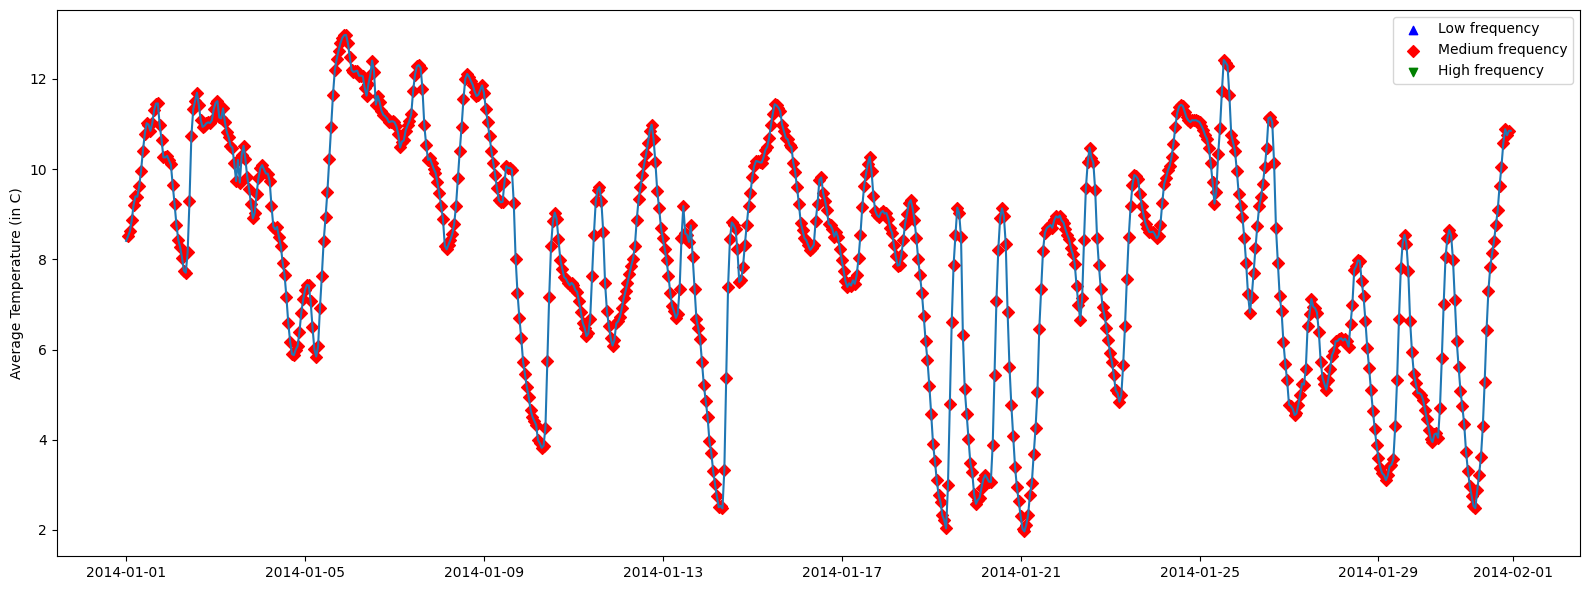

In [77]:
def find_eig(graph_a, graph_b):
    """
    Combine les valeurs propres et vecteurs propres des deux graphes graph_a et graph_b.
    """
    eigenvals_a, eigenvects_a = eigh(graph_a.L.todense())  # Valeurs/vecteurs propres de graph_a
    eigenvals_b, eigenvects_b = eigh(graph_b.L.todense())  # Valeurs/vecteurs propres de graph_b

    eigenvals = []
    eigenvects = []
    # Produit tensoriel des vecteurs propres et somme des valeurs propres
    for eigenval_a, eigenvect_a in zip(eigenvals_a, eigenvects_a):
        for eigenval_b, eigenvect_b in zip(eigenvals_b, eigenvects_b):
            eigenvals.append(eigenval_a + eigenval_b)
            eigenvects.append(np.kron(eigenvect_a, eigenvect_b))

    # Tri des valeurs propres et vecteurs associés
    idx = np.argsort(eigenvals)
    eigenvals = np.array(eigenvals)[idx]
    eigenvects = np.array(eigenvects)[idx]
    return eigenvals, eigenvects.T  # Les vecteurs en colonnes


def compute_dyna_W_at_index(signal, graph_a, graph_b, M=9):
    """
    Calcule les coefficients d'ondelettes dynamiques W pour une donnée signal.
    """
    # Trouver les valeurs/vecteurs propres combinés
    eigenvals, eigenvects = find_eig(graph_a, graph_b)

    # Initialisation de la matrice W
    W = np.zeros((M, len(eigenvects)))

    # Génération des noyaux pour chaque échelle
    g = np.stack([g_m(eigenvals, i, R=3) for i in range(1, 10)])  # Taille M x eigenvals

    # Transformation de Fourier du signal
    f_hat = signal.T @ eigenvects

    # Calcul des coefficients pour chaque noeud
    for idx, v in enumerate(eigenvects):
        ul_v = eigenvects[idx, :]  # Coordonnées des vecteurs propres pour le noeud idx
        w = g * f_hat[None, :] * ul_v[None, :]  # w est de taille M x eigenvals
        W[:, idx] = np.sum(w, axis=1)  # Somme sur toutes les valeurs propres
    return W


# Liste des stations disponibles
station_list = list(set(no_nan_temperature_df.columns) - set(stations_with_nan))

# Définition du graphe en ligne
adjacency_line = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
line_graph = graphs.Graph(adjacency_line)

# Classification principale
major_class = []
for idx in range(1, len(no_nan_temperature_df) - 1):
    # Calcul de W pour la fenêtre temporelle
    W = compute_dyna_W_at_index(
        no_nan_temperature_df.iloc[idx - 1 : idx + 2].to_numpy().flatten(), graph, line_graph
    )
    # Reshape de la matrice W
    W_reshape = W.reshape((M, len(station_list), -1))

    # Somme sur l'axe temporel
    W_reshape = W_reshape.sum(axis=2)
    W_classified = classify_W(W_reshape)

    # Détermination de la classe majoritaire
    values, counts = np.unique(W_classified, return_counts=True)
    major_value = values[np.argmax(counts)]
    major_class.append(major_value)
major_class = np.array(major_class)

# Visualisation des résultats
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# Courbe des températures moyennes
ax.plot(no_nan_temperature_df.index, no_nan_temperature_df.T.mean())

# Ajout des marqueurs par classe
marker_list = ["^", "D", "v"]
color_list = ["blue", "red", "green"]
for major_value in [0, 1, 2]:
    mask = major_class == major_value
    ax.scatter(
        np.array(no_nan_temperature_df.index[1:-1])[mask],
        np.array(no_nan_temperature_df.T.mean()[1:-1])[mask],
        color=color_list[major_value],
        marker=marker_list[major_value],
        label=["Low frequency", "Medium frequency", "High frequency"][major_value],
    )
ax.set_ylabel("Average Temperature (in C)")
ax.legend()
plt.tight_layout()
